##### Импортируем необходимые библиотеки для подготовки и работы с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plot
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

Импортуем данные в формате csv, обработанные в Excel

In [2]:
crm = pd.read_csv(r'C:\Users\User\Documents\qanat\attestation\crm.csv', sep=',', encoding='utf-8', on_bad_lines='skip')
marketing = pd.read_csv(r'C:\Users\User\Documents\qanat\attestation\marketing.csv', sep=',', encoding='utf-8', on_bad_lines='skip')
guide = pd.read_csv(r'C:\Users\User\Documents\qanat\attestation\guide.csv', sep=',', encoding='utf-8', on_bad_lines='skip')

In [3]:
crm.columns

Index(['Client ID', 'Город', 'Просчет стоимости модели', 'Приход к диллеру',
       'Продажа'],
      dtype='object')

In [4]:
marketing.columns

Index(['Client ID', 'Domain', 'City', 'Region', 'Browser', 'Device Category',
       'Date', 'Pageviews', 'Campaign', 'Keyword', 'Medium', 'Source',
       ' Avg. Session Duration', ' Bounce Rate', 'Sessions',
       'Goal Completion Location', 'Goal Completions', 'Goal Conversion Rate',
       'Goal Value', 'Конверсия', 'Source conv.', 'Марка'],
      dtype='object')

In [5]:
guide.columns

Index(['Марка', 'Модель', 'Цена', 'Валюта', 'Маржинальность'], dtype='object')

Получаем из сайта ЦБ РФ курсы валют. Для этого использовали библиотеки requests и BeatifulSoap

In [6]:
url = 'https://www.cbr.ru/currency_base/daily/'

Создаем функцию, где переводим цену и маржинальность в рубли, где указаны валюты доллар США и Евро

In [7]:
# Функция для получения курсов валют с сайта Центрального банка России
def get_exchange_rates():
    url = 'https://www.cbr.ru/currency_base/daily/'
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        table = soup.find('table', {'class': 'data'})
        rows = table.find_all('tr')
        exchange_rates = {}
        for row in rows[1:]:
            cells = row.find_all('td')
            currency = cells[3].text.strip()
            rate = float(cells[4].text.replace(',', '.'))
            exchange_rates[currency] = rate
        return exchange_rates
    else:
        print(f'Ошибка при запросе страницы: {response.status_code}')
        return None

# Получаем текущие курсы валют
exchange_rates = get_exchange_rates()

# Функция для конвертации цен и маржинальности в рубли
def convert_to_rubles(row):
    currency = row['Валюта']
    if currency == 'Доллар США' or currency == 'Евро':
        exchange_rate = exchange_rates.get(currency)
        if exchange_rate is not None:
            row['Цена'] = row['Цена'] * exchange_rate
            row['Маржинальность'] = row['Маржинальность'] * exchange_rate
    return row

# Применяем функцию к каждой строке в DataFrame 'guide'
guide = guide.apply(convert_to_rubles, axis=1)
guide.head()

,Марка,Модель,Цена,Валюта,Маржинальность
0,Mercedes,gls,1.096924e+07,Доллар США,31.889154
1,Mercedes,GT_AMG,1.684562e+07,Доллар США,32.855492
2,BMW,x5,7.441474e+06,Евро,27.819666
3,BMW,i3,5.323516e+06,Евро,36.062530
4,Mercedes,с180,2.300000e+06,Рубль,0.200000


Сумма касаний для каждой цепочки и пользователя и сумма конверсий по цепочкам

In [8]:
# Фильтрация данных (пример фильтрации, может потребоваться более сложная логика)
filtered_data = marketing[marketing['Goal Completions'] > 0]

# Группировка данных по клиенту (Client ID)
grouped_data = filtered_data.groupby('Client ID')

# Создаем столбец для цепочек касаний и сохраняем его в новом DataFrame
touchpoints_df = grouped_data['Campaign'].apply(lambda x: ' > '.join(x)).reset_index()
touchpoints_df.columns = ['Client ID', 'Touchpoints']

# Объединяем полученный DataFrame обратно с исходными данными
merged_data = pd.merge(filtered_data, touchpoints_df, on='Client ID', how='left')

# Рассчет суммы касаний для каждой цепочки и пользователя
touchpoint_counts = merged_data['Touchpoints'].value_counts().reset_index()
touchpoint_counts.columns = ['Touchpoints', 'Touchpoint_Count']

# Определение признака конверсии для каждой цепочки
touchpoint_counts['Conversion'] = touchpoint_counts['Touchpoints'].apply(lambda x: 1 if x.split(' > ')[-1] == 'Conversion' else 0)

# Сумма конверсий по цепочкам
conversion_counts = touchpoint_counts.groupby('Touchpoints')['Conversion'].sum().reset_index()

# Сумма касаний для каждой цепочки и пользователя
touchpoint_sums = touchpoint_counts.groupby('Touchpoints')['Touchpoint_Count'].sum().reset_index()

touchpoint_sums.head(3)

,Touchpoints,Touchpoint_Count
0,(not set),15461
1,(not set) > (not set),5336
2,(not set) > (not set) > (not set),2268


In [9]:
conversion_counts.head(3)

,Touchpoints,Conversion
0,(not set),0
1,(not set) > (not set),0
2,(not set) > (not set) > (not set),0


Из каких регионов больше всего заявок

In [10]:
region_counts = marketing['Region'].value_counts()
region_counts.head(3)

Region
Krasnodar Krai    47648
Stavropol Krai     3246
Rostov Oblast      2388
Name: count, dtype: int64

Какой средний процент отказов (Bounce)

In [12]:
average_bounce_rate = marketing[' Bounce Rate'].mean()
average_bounce_rate

0.0022641365134064874

С каких устройств чаще заходят на сайты

In [13]:
device_counts = marketing['Device Category'].value_counts()
device_counts

Device Category
mobile     39465
desktop    24630
tablet      2067
Name: count, dtype: int64

Какие источники наиболее конвертируемые

In [14]:
conversion_rates_by_source = marketing.groupby('Source')['Goal Conversion Rate'].mean().sort_values(ascending=False)
conversion_rates_by_source

Source
crm2company.streamwood.ru    1.0
alohafind.com                1.0
tut.by                       1.0
min.rusdealers.ru            1.0
kuban.autoneva.ru            1.0
                            ... 
bridgetsimon.top             0.0
avto25.ru                    0.0
auto.drom.ru                 0.0
192.168.8.1                  0.0
честно-отзыв.рф              0.0
Name: Goal Conversion Rate, Length: 88, dtype: float64

Рассчитайте ROMI

In [18]:
marketing['ROMI'] = (marketing['Goal Value'] / crm['Продажа']) * 100
marketing['ROMI']

0        inf
1        inf
2        inf
3        NaN
4        inf
        ... 
66157    inf
66158    inf
66159    inf
66160    NaN
66161    NaN
Name: ROMI, Length: 66162, dtype: float64

Определите, какой источник трафика наиболее выгоден для компании по текущим данным

In [17]:
romi_by_source = marketing.groupby('Source')['ROMI'].mean().sort_values(ascending=False)
romi_by_source

Source
(direct)                 inf
google.com               inf
min.rusdealers.ru        inf
m.facebook.com           inf
link.2gis.ru             inf
                        ... 
krasnodar.spravker.ru    NaN
msk.autoneva.ru          NaN
rnd.autoneva.ru          NaN
stavropol.drom.ru        NaN
yandex.com.tr            NaN
Name: ROMI, Length: 88, dtype: float64

Объединим таблицы

In [19]:
merged_data = pd.merge(marketing, crm, on='Client ID', how='inner')
merged_data.head(3)

,Client ID,Domain,City,Region,Browser,Device Category,Date,Pageviews,Campaign,Keyword,...,Goal Conversion Rate,Goal Value,Конверсия,Source conv.,Марка,ROMI,Город,Просчет стоимости модели,Приход к диллеру,Продажа
0,GA1.2.1029165320.1581675414,BMW-keyauto-krd.ru,Zurich,Zurich,Chrome,mobile,14-02-20,18,(not set),(not set),...,1.0,38039,1,cars.BMW-keyauto-krd.ru,BMW,inf,Zurich,0,1,0
1,GA1.2.1029165320.1581675414,BMW-keyauto-krd.ru,Zurich,Zurich,Chrome,mobile,14-02-20,18,(not set),(not set),...,1.0,38039,1,cars.BMW-keyauto-krd.ru,BMW,inf,Zurich,0,0,0
2,GA1.2.1029165320.1581675414,BMW-keyauto-krd.ru,Zurich,Zurich,Chrome,mobile,14-02-20,18,(not set),(not set),...,1.0,38039,1,cars.BMW-keyauto-krd.ru,BMW,inf,Zurich,1,1,0


Создаем карту продаж

c:\Users\User\.virtualenvs\attestation-HMBreOa0\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\.virtualenvs\attestation-HMBreOa0\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\.virtualenvs\attestation-HMBreOa0\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\.virtualenvs\attestation-HMBreOa0\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

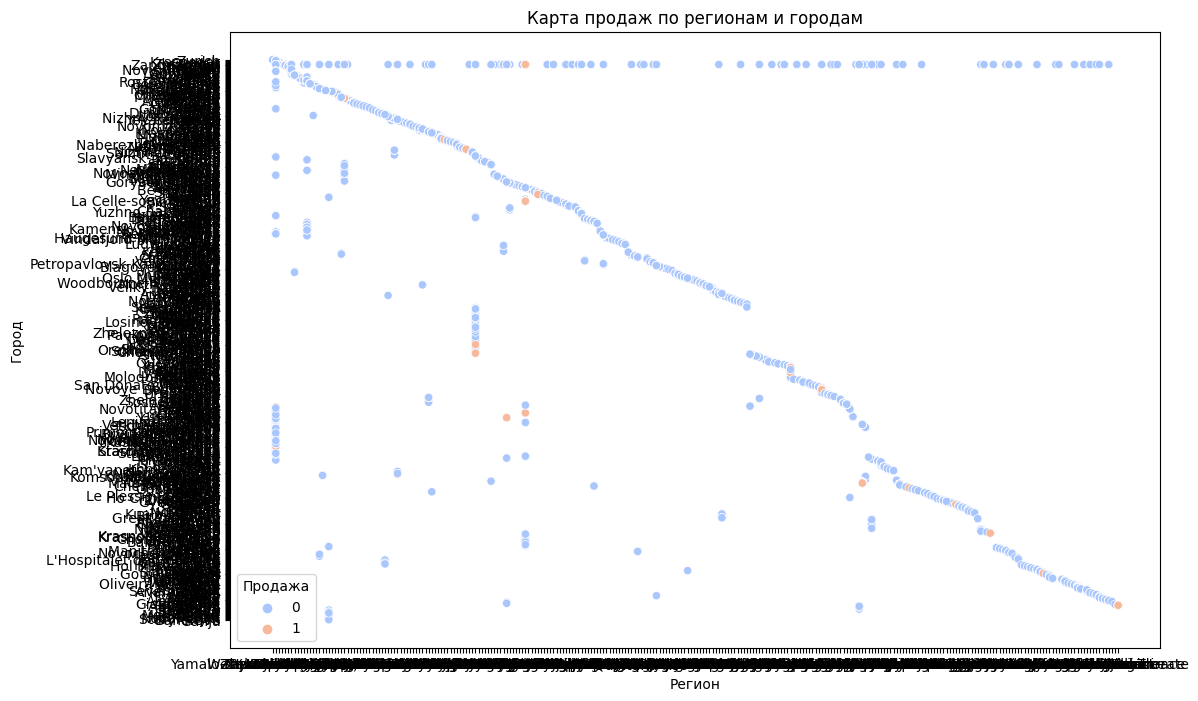

In [20]:
# Создаем карту продаж
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Region', y='City', hue='Продажа', data=merged_data, palette='coolwarm')
plt.xlabel('Регион')
plt.ylabel('Город')
plt.title('Карта продаж по регионам и городам')
plt.show()

Создаем график с раскраской, но визуально видно, что где-то есть ошибка

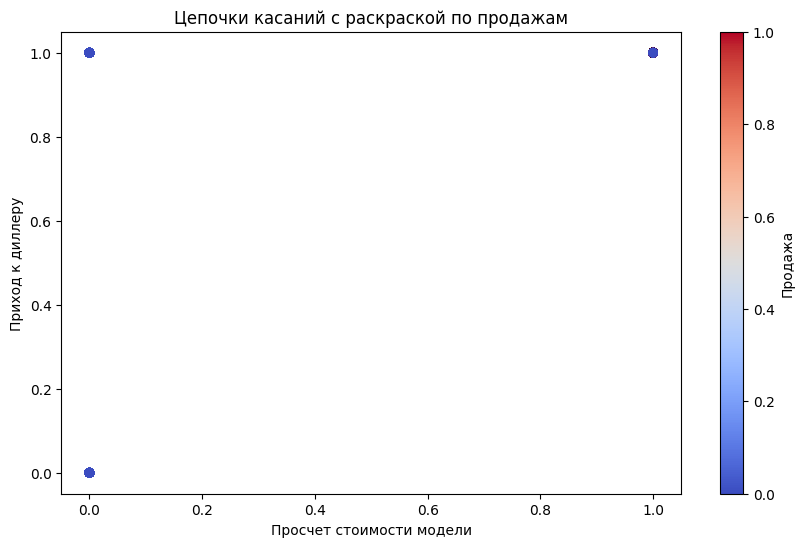

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Просчет стоимости модели'], merged_data['Приход к диллеру'], c=merged_data['Продажа'], cmap='coolwarm')
plt.xlabel('Просчет стоимости модели')
plt.ylabel('Приход к диллеру')
plt.title('Цепочки касаний с раскраской по продажам')
plt.colorbar(label='Продажа')
plt.show()

Создаем матрицу продаж по авто

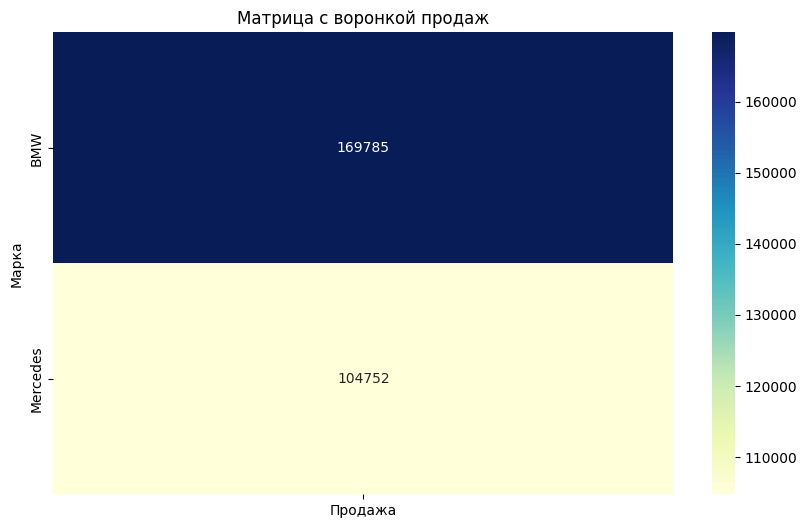

In [23]:
plt.figure(figsize=(10, 6))
pivot_table = merged_data.pivot_table(values='Продажа', index='Марка', aggfunc='count', fill_value=0)
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Матрица с воронкой продаж')
plt.show()

Создаем график с линией отсечки

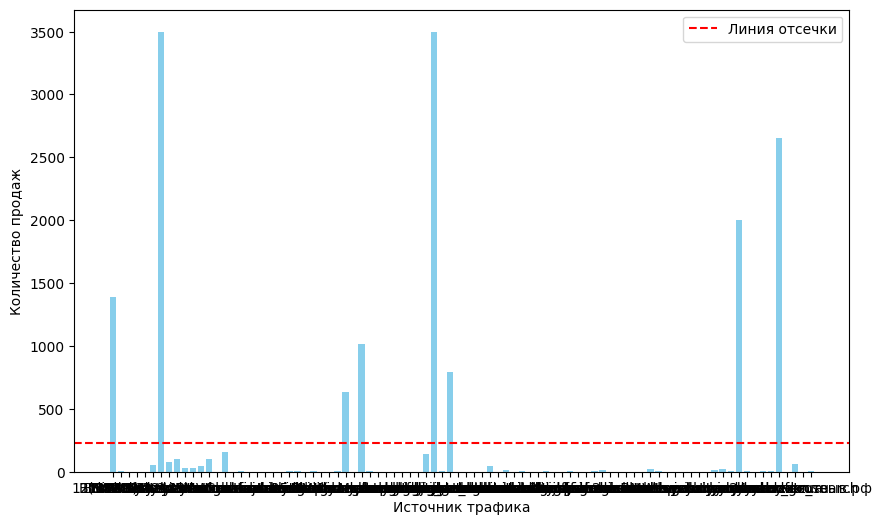

In [24]:
plt.figure(figsize=(10, 6))
traffic_sales = merged_data.groupby('Source')['Продажа'].sum().reset_index()
plt.bar(traffic_sales['Source'], traffic_sales['Продажа'], color='skyblue')
plt.axhline(y=230, color='red', linestyle='--', label='Линия отсечки')
plt.xlabel('Источник трафика')
plt.ylabel('Количество продаж')
plt.legend()
plt.show()

Создаем графики для декомпозиции

C:\Users\User\AppData\Local\Temp\ipykernel_13984\315343213.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


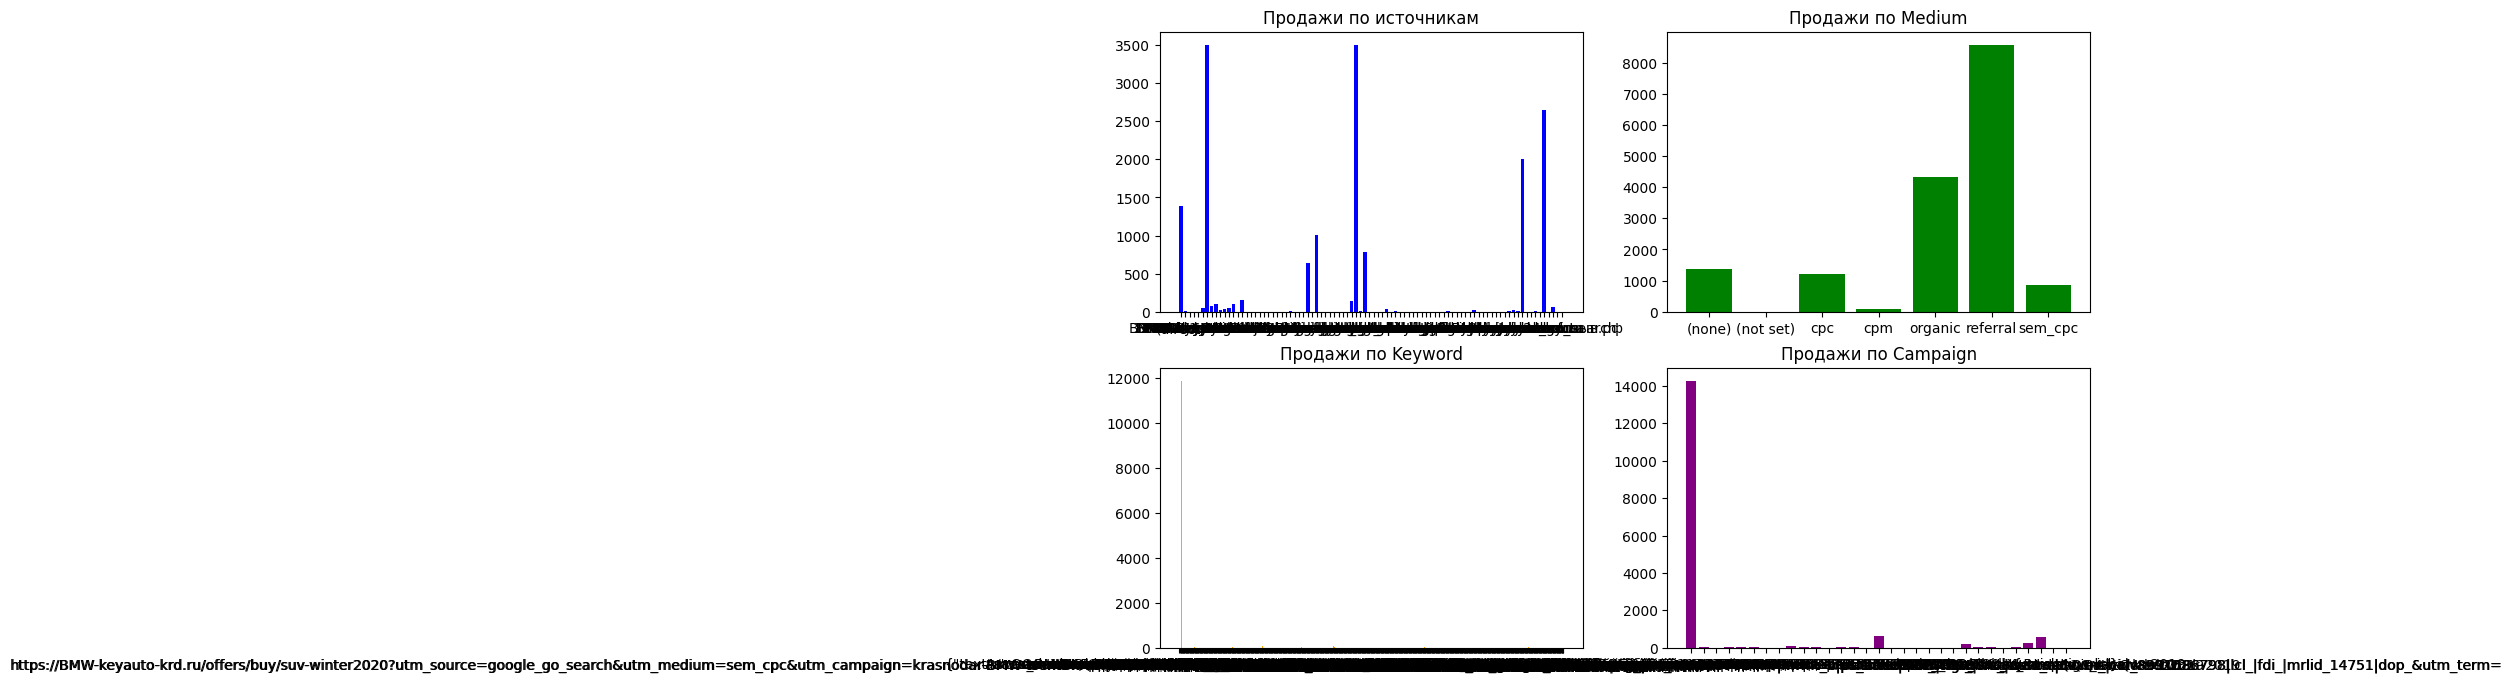

In [25]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
source_sales = merged_data.groupby('Source')['Продажа'].sum().reset_index()
plt.bar(source_sales['Source'], source_sales['Продажа'], color='blue')
plt.title('Продажи по источникам')

plt.subplot(2, 2, 2)
medium_sales = merged_data.groupby('Medium')['Продажа'].sum().reset_index()
plt.bar(medium_sales['Medium'], medium_sales['Продажа'], color='green')
plt.title('Продажи по Medium')

plt.subplot(2, 2, 3)
keyword_sales = merged_data.groupby('Keyword')['Продажа'].sum().reset_index()
plt.bar(keyword_sales['Keyword'], keyword_sales['Продажа'], color='orange')
plt.title('Продажи по Keyword')

plt.subplot(2, 2, 4)
campaign_sales = merged_data.groupby('Campaign')['Продажа'].sum().reset_index()
plt.bar(campaign_sales['Campaign'], campaign_sales['Продажа'], color='purple')
plt.title('Продажи по Campaign')

plt.tight_layout()
plt.show()

Среднее количество касаний в цепочке

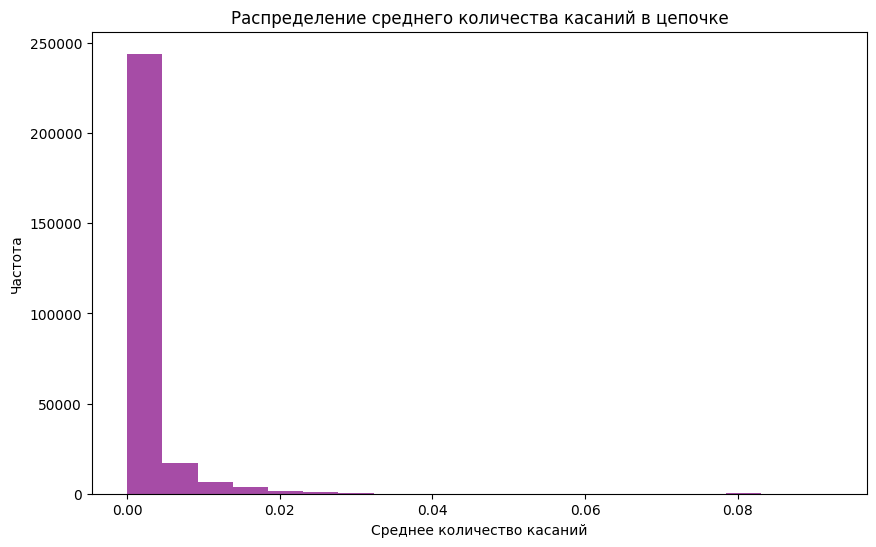

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(merged_data[' Avg. Session Duration'], bins=20, color='purple', alpha=0.7)
plt.xlabel('Среднее количество касаний')
plt.ylabel('Частота')
plt.title('Распределение среднего количества касаний в цепочке')
plt.show()